## Assignment 04

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, Subset
from torch.utils.data.sampler import SubsetRandomSampler
import random as rand
import PIL

from utils import CutMix, OneHot, show_grid, reject_randomness
from utils import plot_history, plot_samples, get_best_accuracy

In [2]:
# first reject randomness
reject_randomness(2021)

#### Custom Dataset and Data Augmentation

##### CutMix setup

For more details and usage examples on common datasets see *CutMix_Demo.ipynb*!

In [3]:
# now set up data augmentation
# data transforms which are applied before CutMix
pre_transforms_list = [
        transforms.Resize(256),
        transforms.CenterCrop(224)]
pre_transforms = transforms.Compose(pre_transforms_list)

# create dataset from which CutMix draws
data_dir = 'data/images'
cutmix_dataset = datasets.ImageFolder(data_dir, pre_transforms)
# configure how much of the dataset to use for training
# Note: data available to CutMix is exactly the data available to training!
train_share = 0.8
N_samples = len(cutmix_dataset)
indices = list(range(N_samples))
split = int(np.ceil(train_share * N_samples))
np.random.shuffle(indices)
# split dataset
train_idx, valid_idx = indices[:split], indices[split:]
# constrain CutMix data to training set
cutmix_dataset = Subset(cutmix_dataset, train_idx)

# prepare seed for the CutMix RNG
# this must be shared between the data and target transform instances of CutMix
random_random_seed = np.random.randint(1e10)
print('The shared CutMix random seed is', random_random_seed)

The shared CutMix random seed is 9620755398


##### Configuration of validation loader and augmented training loader

In [4]:
# now prepare the data augmentation
# the following values should correspond to model pre-training
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms applied before CutMix were defined above already
# they have to be prepended to the transforms applied to the training set
data_transforms = {
    'train': transforms.Compose(pre_transforms_list +
        [CutMix(dataset=cutmix_dataset, seed=random_random_seed, num_classes=2),
         transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
# load the same dataset twice using different transforms
train_dataset = datasets.ImageFolder(data_dir, transform=data_transforms["train"], target_transform=CutMix(dataset=cutmix_dataset, seed=random_random_seed, num_classes=2))
# note that the targets for the valid set are one-hot encoded for consistency
valid_dataset = datasets.ImageFolder(data_dir, transform=data_transforms["valid"], target_transform=OneHot(num_classes=2))
# restrict the dataloaders to only training or validation using samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# configure the corresponding dataloaders using the corresponding sampler
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, sampler=valid_sampler)

# print some dataset info
class_names = train_dataset.classes
print('The classes are:', class_names)
print('Total number of samples:', N_samples)
print('Number of samples in the training set:', len(train_idx))
print('Number of samples in the validation set:', len(valid_idx))

The classes are: ['person', 'robot']
Total number of samples: 253
Number of samples in the training set: 203
Number of samples in the validation set: 50


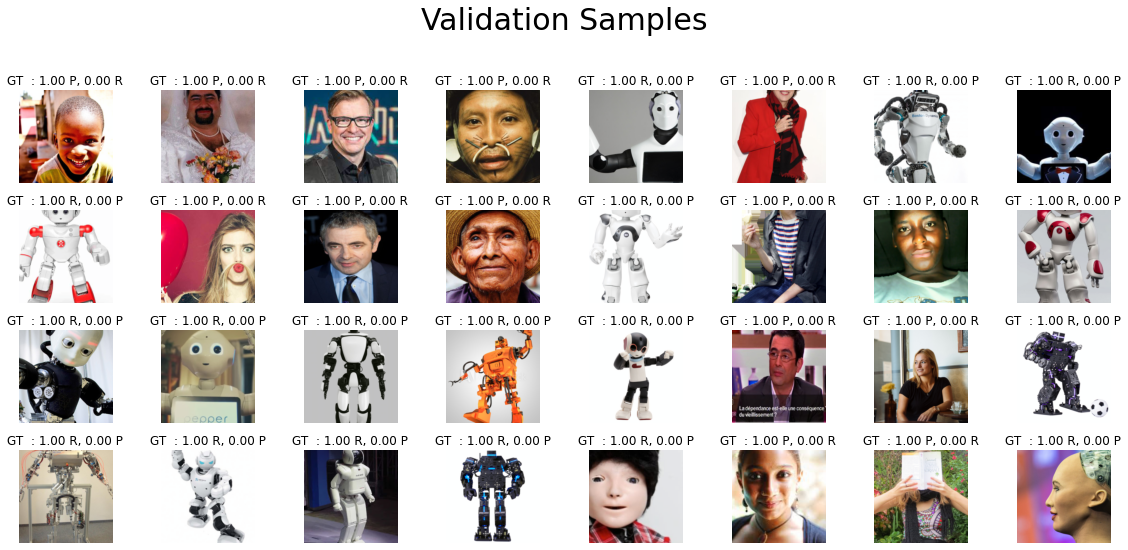

In [5]:
# Get a batch of validation data and display it
inputs, classes = next(iter(valid_loader))
labels = [label for label in classes]
show_grid(inputs, labels=labels, mean=mean, std=std, description='Validation Samples')

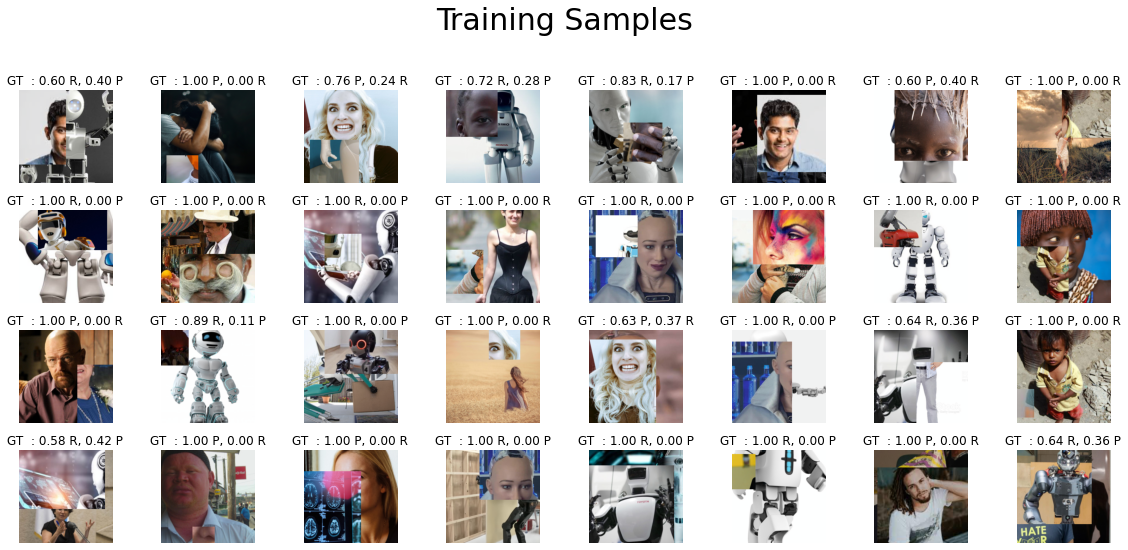

In [6]:
# Get a batch of training data and display it
inputs, classes = next(iter(train_loader))
labels = [label for label in classes]
show_grid(inputs, labels=labels, mean=mean, std=std, description='Training Samples')

#### Experiments with pre-trained models

##### Custom losses for one-hot encoded targets and label-mixture-targets

Most classification metrics expect integer class label targets, but the targets produced by CutMix are mixtures of labels. We can generalize the former to the latter by producing a sum of metrics weighted by the mixture coefficients. This is an abstraction based on the loss calculation found in the CutMix git repository.

In [7]:
# wraps a criterion like CrossEntropyLoss
# the criterion then accepts:
# - onehot encoded labels or
# - label mixtures as produced by CutMix
# criterion in: NxC unnormalized class scores, N integer target labels
# make sure to set reduction of criterion to 'none'
# wrapped criterion in: x: N by C unnormalized scores, target N by C label mixtures
# wrapped criterion out: mean MixLoss
class MultiLabelMixLoss(nn.Module):
    def __init__(self, criterion):
        super(MultiLabelMixLoss, self).__init__()
        self.criterion = criterion
    def forward(self, x, target):
        loss = 0.
        for i in range(target.shape[-1]):
            loss += target[:,i]*self.criterion(x, torch.full_like(target[:,i],i).long())
        return loss.mean()

# accuracy is only useful on the validation data
class OneHotAccuracy(nn.Module):
    def __init__(self):
        super(OneHotAccuracy, self).__init__()
    def forward(self, x, target):
        return (x.argmax(dim=-1) == target.argmax(dim=-1)).float().mean() * 100

##### Helper functions which provide pretrained models adjusted to our needs

In [8]:
def get_vgg(freeze_features=False, out_features=2):
    model = models.vgg16(pretrained=True)
    classifier_list = list(model.classifier.children())
    num_neurons = classifier_list[-1].in_features
    classifier_list[-1] = nn.Linear(num_neurons, out_features)
    if freeze_features:
        for param in model.features.parameters():
            param.requires_grad = False
    model.classifier = nn.Sequential(*classifier_list)
    return model

def get_densenet(freeze_features=False, out_features=2):
    model = models.densenet161(pretrained=True)
    classifier_list = [model.classifier]
    num_neurons = classifier_list[-1].out_features
    classifier_list += [nn.Dropout(), nn.Linear(num_neurons, out_features)]
    if freeze_features:
        for param in model.features.parameters():
            param.requires_grad = False
    model.classifier = nn.Sequential(*classifier_list)
    return model

def get_resnet(freeze_features=False, out_features=2):
    model = models.resnet18(pretrained=True)
    if freeze_features:
        for param in model.parameters():
            param.requires_grad = False
    num_logits = model.fc.in_features
    model.fc = nn.Linear(num_logits, out_features)
    return model

##### Trainer class

Training, logging and saving is handled by a trainer class. We do not highlight it here, because it is based mostly on the training function which we needed for the optuna study on the previous assignment. The logging and saving is mostly according to code presented in lab session 4. The definition and a short description is in *trainer.py*.

In [9]:
from trainer import Trainer
# define the metrics we want to track in addition to the training criterion
eval_metrics = {
  "accuracy": OneHotAccuracy()
}

# define criterion
criterion = nn.CrossEntropyLoss(reduction='none')
# adjust to CutMix or OneHot targets
criterion = MultiLabelMixLoss(criterion)

##### VGG

Fine-tuned

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


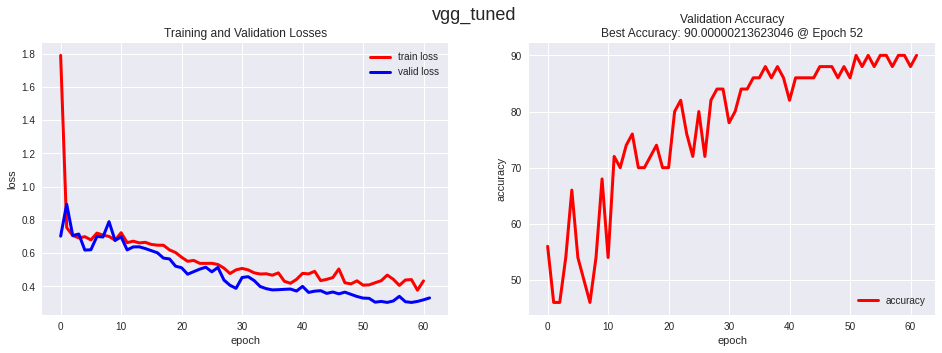

In [10]:
model = get_vgg(freeze_features=False)

title = 'vgg_tuned'
vgg_tuned_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, es_mode='max', description=title)
vgg_tuned_trainer.fit()

# visualize training process
plot_history(vgg_tuned_trainer)

##### VGG

Frozen

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


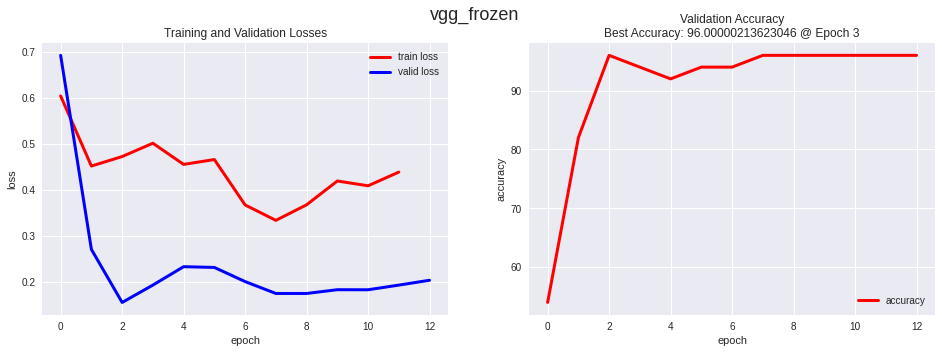

In [11]:
model = get_vgg(freeze_features=True)

title = 'vgg_frozen'
vgg_frozen_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, es_mode='max', description=title)
vgg_frozen_trainer.fit()

# visualize training process
plot_history(vgg_frozen_trainer)

##### ResNet

Fine-tuned

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


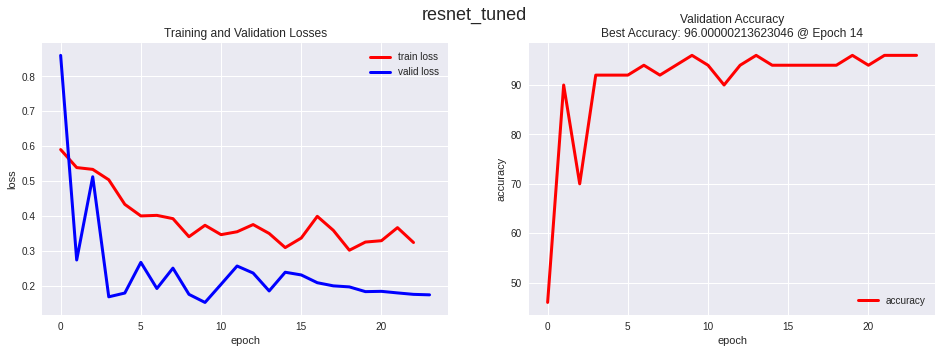

In [12]:
model = get_resnet(freeze_features=False)

title = 'resnet_tuned'
resnet_tuned_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, es_mode='max', description=title)
resnet_tuned_trainer.fit()

# visualize training process
plot_history(resnet_tuned_trainer)

##### ResNet

Frozen

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


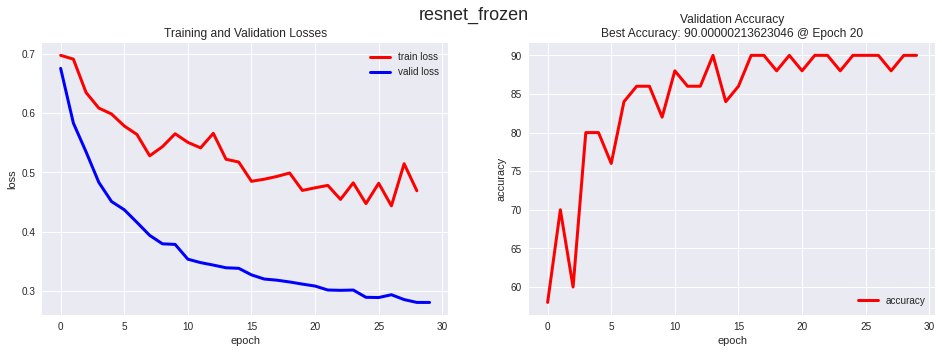

In [13]:
model = get_resnet(freeze_features=True)

title = 'resnet_frozen'
resnet_frozen_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, es_mode='max', description=title)
resnet_frozen_trainer.fit()

# visualize training process
plot_history(resnet_frozen_trainer)

##### DenseNet

Fine-tuned

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


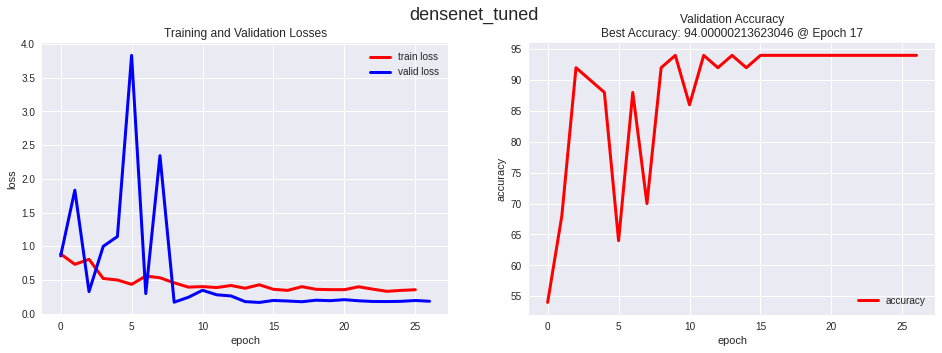

In [14]:
model = get_densenet(freeze_features=False)

title = 'densenet_tuned'
densenet_tuned_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, es_mode='max', description=title)
densenet_tuned_trainer.fit()

# visualize training process
plot_history(densenet_tuned_trainer)

##### DenseNet

Frozen

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


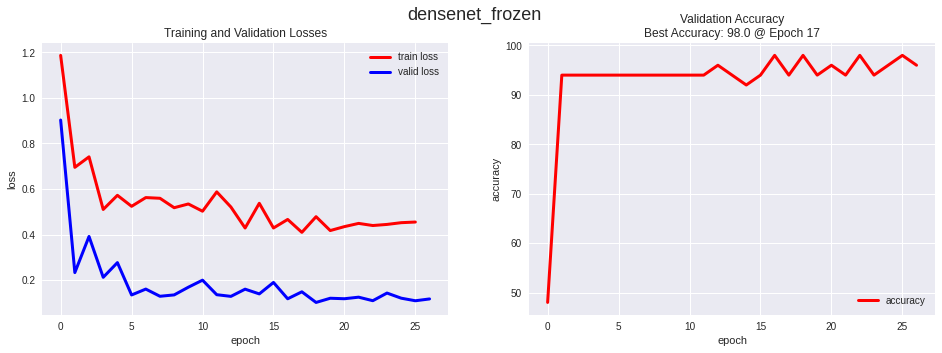

In [15]:
model = get_densenet(freeze_features=True)

title = 'densenet_frozen'
densenet_frozen_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, es_mode='max', description=title)
densenet_frozen_trainer.fit()

# visualize training process
plot_history(densenet_frozen_trainer)

#### Appraisal

First we examine the trade-off between training times and accuracy for each of the tested models.

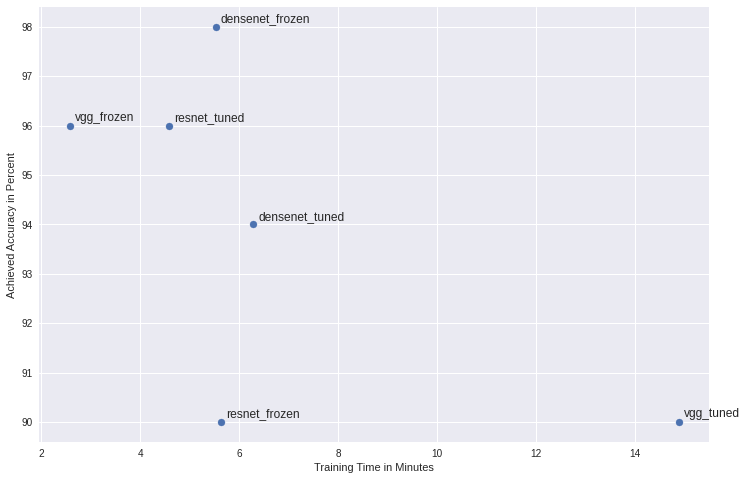

In [22]:
trainer_list = [vgg_tuned_trainer, vgg_frozen_trainer, resnet_tuned_trainer, resnet_frozen_trainer,
                densenet_tuned_trainer, densenet_frozen_trainer]
trainer_labels = [trainer.description for trainer in trainer_list]
trainer_times = [trainer.training_time / 60 for trainer in trainer_list]
trainer_best_acc = [get_best_accuracy(trainer)[0] for trainer in trainer_list]

plt.style.use('seaborn')
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.scatter(trainer_times, trainer_best_acc)
ax.set_xlabel("Training Time in Minutes")
ax.set_ylabel("Achieved Accuracy in Percent")

for i, txt in enumerate(trainer_labels):
    ax.annotate(txt, (trainer_times[i], trainer_best_acc[i]), xycoords='data',
            xytext=(5, 5), textcoords='offset points', fontsize=12)
plt.show()

Of course, we want an accuracy which is as high as possible, but the training times should also be short. From this point of view, we think *vgg_frozen* offers a good ratio even though it is a massive model. The best accuracy, which was achieved by the frozen DenseNet, also has a very acceptable training time, so this is a good option too. In general, fine-tuning always took longer than training just the classifier, but the result is also better for the latter. The one exception is ResNet, where neither is true. However, the results should be taken with a grain of salt because the training process was not optimized for any model. However, good scores across the board speak in favor of the trainer class. Based on these results, there is no reason to consider any of the models 'sabotaged' by the training process.

Next, we also present the results qualitatively. Since *vgg_frozen* is our model of choice based on the good trade-off between accuracy and training time, we display some samples from training and validation sets for it.

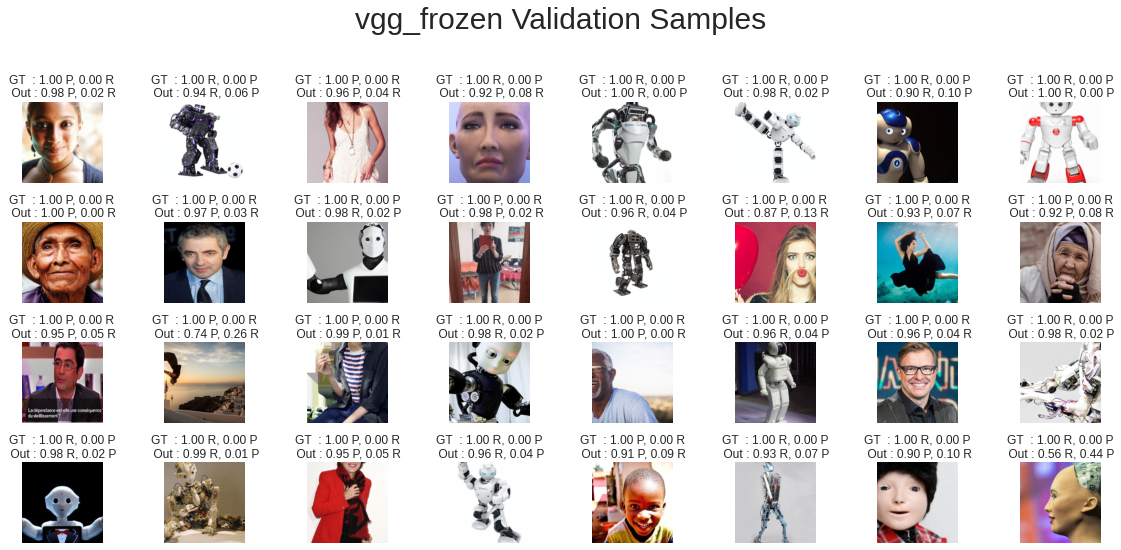

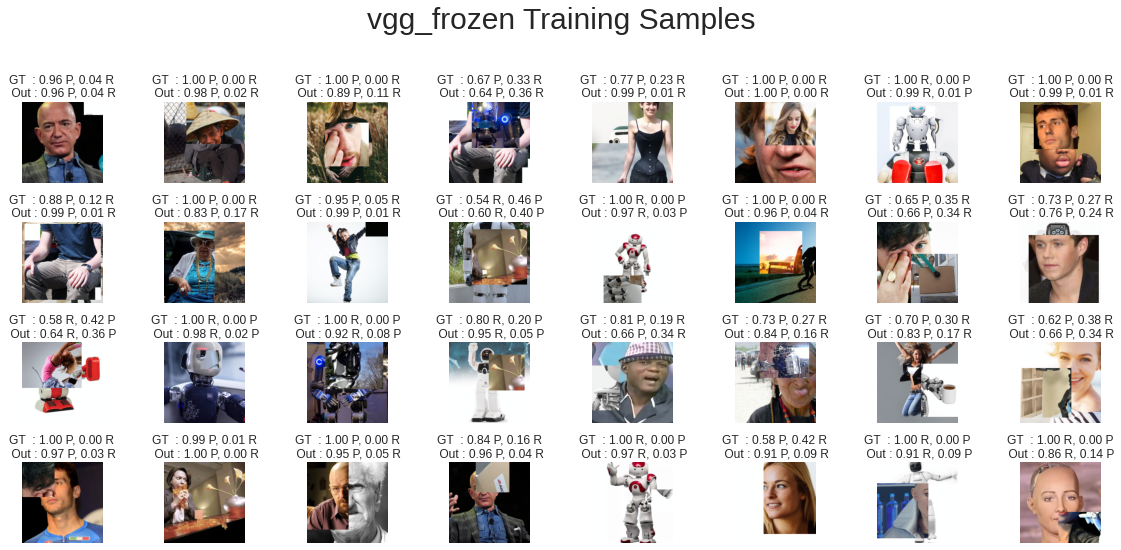

In [21]:
# show samples for best model
plot_samples(vgg_frozen_trainer)

On the validation set, the model is mostly very confident in its choice, and its choice is almost always correct, as is expected by the high validation accuracy. Two glaring mistakes are the image in the last row, second to last column, and first row, fourth column of the valdation set sample. In these cases it is plausible that they are difficult to classify, even though a human probably would have managed it. The image in the bottom right corner, however, is barely correct but also a difficult one to classify, reflected in an almost undecided score mixture.

The training set is more interesting because the model has to deal with the CutMixed images and targets here. For most images, the model actually manages to approximate the ground truth label mixture very well. The exceptions, for example the final row third-to-last column, are plausible, as one of the transplanted images shows only its white background. Intuitively, it seems desirable to have the effect which CutMix introduces here.

#### Addendum

##### SqueezeNet

To demonstrate that our training scheme is actually 'useful', we load, adapt and train another architecture, the tiny SqueezeNet. Keeping the feature extraction frozen, training is complete within about 3 minutes, achieving an accuracy larger than 90% on the validation set.

In [18]:
def get_squeezenet(freeze_features=False, out_features=2):
    model = models.squeezenet1_1(pretrained=True)
    classifier_list = list(model.classifier.children())
    num_channels = classifier_list[1].in_channels
    classifier_list[1] = nn.Conv2d(num_channels, out_features, kernel_size=(1,1), stride=(1,1))  
    if freeze_features:
        for param in model.features.parameters():
            param.requires_grad = False
    model.classifier = nn.Sequential(*classifier_list)
    return model

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


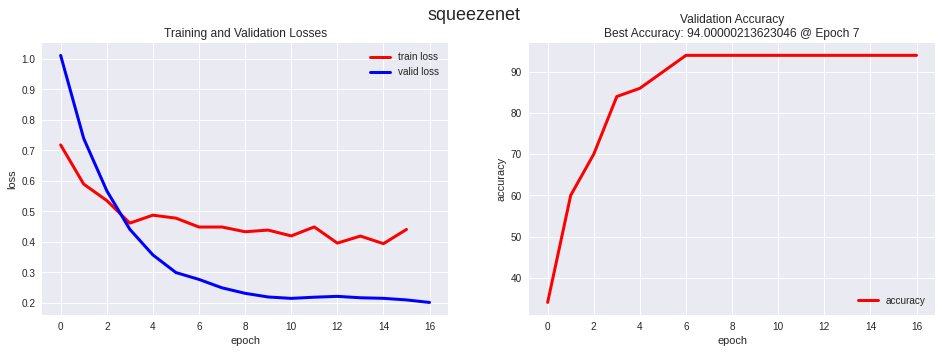

In [19]:
model = get_squeezenet(freeze_features=True)
title = 'squeezenet'
squeezenet_frozen_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, es_mode='max', description=title)
squeezenet_frozen_trainer.fit()

# visualize training process
plot_history(squeezenet_frozen_trainer)

The trained model is then recovered from the trainer and saved again in an outdated manner for reasons of backwards-compatibility.

In the file *Assignment_04_Addendum.ipynb*, which was executed on a **Raspberry Pi Zero** with 512MB RAM and a 1GHz single-core ARMv6 CPU, we demonstrate reliable classification at about 0.5 fps of some images which were not included in the training nor the validation set, using a frozen SqueezeNet with a classifier retrained on our small custom dataset above. Thus, learned representations have been transfered not only from ImageNet to our custom dataset, but also from a powerful computer to what some would call essentially a microcontroller.

In [20]:
#model_to_save = squeezenet_frozen_trainer.model.cpu()
#savepath = f"models/{title}_slim.pt"
#torch.save(model_to_save.state_dict(), savepath, _use_new_zipfile_serialization=False)